# Implementing ANNs with Tensorflow
## Homework 3 - 18/11/17
#### Auss Abbood, John Berroa, Luke Effenberger

# Task 2
Downloaded

# Task 3
Now let's investigate the data.  Let's load the data and plot some pictures as well as their labels.  We'll also see the amount of data we have.  We will use Lukas' function to load the data

In [1]:
# Imports...
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Data class from Lukas
class CIFAR():
    def __init__(self, directory = "./"):
        self._directory = directory
        
        self._training_data = []
        self._training_labels = []
        self._test_data = []
        self._test_labels = []
        self._mean = []
        self._std = []
        
        self._load_traing_data()
        self._load_test_data()
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)

    def set_mean_and_std(self):
        mean_red = np.mean(self._training_data[:,:,:,0], axis=0)
        mean_blue = np.mean(self._training_data[:,:,:,1], axis=0)
        mean_green = np.mean(self._training_data[:,:,:,2], axis=0)
        self._mean = np.array([mean_red,mean_blue,mean_green])
        
        std_red = np.std(self._training_data[:,:,:,0], axis=0)
        std_blue = np.std(self._training_data[:,:,:,1], axis=0)
        std_green = np.std(self._training_data[:,:,:,2], axis=0)
        self._std = np.array([std_red,std_blue,std_green])
    
    def _load_traing_data(self):
        for i in range(1, 6):
            path = os.path.join(self._directory, "data_batch_" + str(i))
            with open(path, 'rb') as fd:
                cifar_data = pickle.load(fd, encoding = "bytes")
                imgs = cifar_data[b"data"].reshape([-1, 3, 32, 32])
                imgs = imgs.transpose([0, 2, 3, 1])
                if i == 1:
                    self._training_data = imgs
                    self._training_labels = cifar_data[b"labels"]
                else:
                    self._training_data = np.concatenate([self._training_data, imgs], axis = 0)
                    self._training_labels = np.concatenate([self._training_labels, cifar_data[b"labels"]])
        self.set_mean_and_std()
    
    def _load_test_data(self):
        path = os.path.join(self._directory, "test_batch")
        with open(path, 'rb') as fd:
            cifar_data = pickle.load(fd, encoding = "bytes")
            imgs = cifar_data[b"data"].reshape([-1, 3, 32, 32])
            self._test_data = imgs.transpose([0, 2, 3, 1])
            self._test_labels = np.array(cifar_data[b"labels"])
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n


In [3]:
# Create the data object
cifar = CIFAR('./cifar10')

There are 45000 training images, 5000 validation images, and 10000 test images.
The shapes of the images are: (32, 32, 3)


<IPython.core.display.Javascript object>


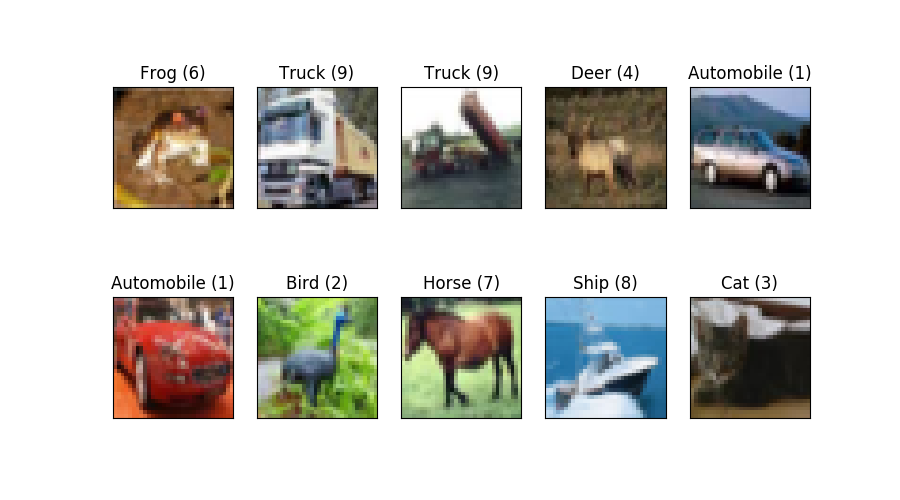

In [4]:
# Get the size of the data so we know what we are working with
n_training, n_valid, n_test = cifar.get_sizes()
print("There are {} training images, {} validation images, and {} test images.".format(n_training, n_valid, n_test))
print("The shapes of the images are: {}".format(cifar._training_data[0].shape))

# Create the string labels for the classes, which are provided as numbers
string_labels = ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']

# Pull out the first 5 training images and their labels for plotting
plotting_samples = cifar._training_data[:10]
plotting_labels = cifar._training_labels[:10]

fig = plt.figure(figsize = (9,5))

for i in range(len(plotting_samples)):
    fig.add_subplot(2,5,i+1)
    plt.imshow(plotting_samples[i], cmap='gray')
    title = "{} ({})".format(string_labels[plotting_labels[i]], plotting_labels[i])
    plt.title(title)
    plt.xticks([], [])
    plt.yticks([], [])

plt.show()

# Task 4
Now let's look at the number of parameters and such that the network we have to implement has.

We'll use some python math to calculate this stuff because doing it by hand is oldschool :D

In [5]:
print("How many neurons?")
nr_neurons = 16*32*32 + 16*16*16 + 32*16*16 + 32*8*8 + 512 + 10
print(nr_neurons)
print("How many degrees of freedom?")
nr_dof = 16*5*5*3 + 32*3*3*16 + 32*8*8*512 + 512*10
print(nr_dof)
print("How many floating-point operations?")
nr_fl_op = 16*32*32* (2*5*5*3-1) + 32*16*16 * (2*3*3*16-1) + (2*(32*8*8)**2-1)*512 + (2*512**2-1)*10
print(nr_fl_op)

How many neurons?
31242
How many degrees of freedom?
1059504
How many floating-point operations?
4305001974


# Task 5
Including all subparts

We make another class that creates a conv network for us, with the network structure specified in the homework.  We add a function to normalize the images before sending them into the network.

We need placeholders for our inputs and labels, and the inputs need to be of shape (x, y, c) where c is the number of color channels.  We need variables for the weights, biases, and kernels.

In [6]:
import tensorflow as tf

In [14]:
class Conv_Net():
    def __init__(self, batchsize, epoch_num, lr=.001, optimizer='standard', norm=False, kern1=5, kern2=3):
        """
        Defines the hyperparameters and creates the datasets
        """
        # Initialize the hyperparameters
        self.batch_size = batchsize
        self.learning_rate = lr
        self.epochs = epoch_num
        self.optimizer_choice = optimizer
        
        # Initialize the size of the kernels if we want to change them
        self.kern1 = kern1
        self.kern2 = kern2
        
        # Create an MNIST data class
        self.data = CIFAR('./cifar10')
        
        # Initialize whether or not to normalize the images
        self.norm = norm
        self._mean = self.data._mean
        self._std = self.data._std
        
        # Create training sets and a session that can be accessed throughout the class
        self.session = tf.Session()
        self.training = self.data.get_training_batch(self.batch_size)
        self.validation = self.data.get_validation_batch(-1)
        self.test = self.data.get_test_batch(-1)
        
        # Create lists to hold the statistics of the network
        self.loss_list = []
        self.acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []
    
    def one_hot(self, lbls):
        """
        Creates one hot labels of the inputting labels, e.g. if airplane, it creates [1,0,0,0,0,0...]
        We may decide to use the tensorflow operation for this later on, but we will keep the function just in case
        Params:
        lbls: an int of the label
        Returns: one hot version of inputed label
        """
        one_hots = []
        for i, l in enumerate(lbls):
            to_one_hot = np.asarray([0]*10)
            to_one_hot[l] = 1
            one_hots.append(to_one_hot)
        return one_hots

    def normalize_batch(self, batch):
        """
        Normalizes the images across channels
        Params:
        batch: the batch to be normalized
        Returns: the normalized batch
        """
        for i in range(len(batch)):
            for col in range(3):
                batch[i,:,:,col] = (batch[i,:,:,col]-self._mean[col]).astype(np.uint8)
                batch[i,:,:,col] = (batch[i,:,:,col]/self._std[col]).astype(np.uint8)
        return batch
    
    def create_and_learn(self):
        """
        The data flow graph.  Creates the graph and trains it on the data.  Also contains two functions, validate and test_final
        """
        def validate():
            """
            Runs the dataflow graph with the validation data.
            """
            valid_loss = 0
            valid_acc = 0
            for batch in self.validation:
                valid_batch = batch[0]
                if self.norm: # normalize the images if we wanted to
                    valid_batch = self.normalize_batch(batch[0])
                onehotz_val = self.one_hot(batch[1])
                va, vl = self.session.run([accuracy, loss], feed_dict={images: valid_batch, labels: onehotz_val})
                valid_loss += vl
                valid_acc += va
            self.val_loss_list.append(np.mean(valid_loss))
            self.val_acc_list.append(np.mean(valid_acc))
            self.validation = self.data.get_validation_batch(-1)  # recreate the iterator because it is now empty

        def test_final():
            """
            Runs the dataflow graph with the test data.  Only run this when a good model is found!
            """
            test_acc_list = []
            test_loss_list = []
            for batch in self.test:
                test_batch = batch[0]
                if self.norm: # normalize the images if we wanted to
                    test_batch = self.normalize_batch(batch[0])
                onehotz_test = self.one_hot(batch[1])
                test_acc, test_loss = self.session.run([accuracy, loss], feed_dict={images: test_batch, labels: onehotz_test})
                test_acc_list.append(test_acc)
                test_loss_list.append(test_loss)
            print("The final network produces results of\n\nACCURACY: {:.2%}\nLOSS: {:.2f}\n\n".format(test_acc, test_loss))
            print("The hyperparameters and optimizer were:")
            print("\n\nBATCH SIZE: {}\nLEARNING RATE: {}\nEPOCHS: {}\nNORMALIZATION: {}\nOPTIMIZER: {}".format(
                    self.batch_size, self.learning_rate, self.epochs, self.norm, self.optimizer_choice))
            

        # Define the number of kernels and such for easy use
        conv1_kern = 16
        conv2_kern = 32
        
        # Define the dataflow graph
        images = tf.placeholder(tf.float32, [None, 32, 32, 3])
        labels = tf.placeholder(tf.float32, [None, 10])
        
        # Define the parameters for the conv layers
        conv1_weights = tf.Variable(tf.truncated_normal([self.kern1, self.kern1, 3, conv1_kern], stddev=.1), dtype=tf.float32)
        conv2_weights = tf.Variable(tf.truncated_normal([self.kern2, self.kern2, conv1_kern, conv2_kern], stddev=.1), dtype=tf.float32)
        conv1_bias = tf.Variable(tf.constant(0.0, shape=[conv1_kern]), dtype=tf.float32)
        conv2_bias = tf.Variable(tf.constant(0.0, shape=[conv2_kern]), dtype=tf.float32)
        
        # Define the feedforward layer parameters
        ff1_weights = tf.Variable(tf.truncated_normal([8*8*conv2_kern, 512], stddev=.00001), dtype=tf.float32)
        ff1_bias = tf.Variable(tf.constant(0.0, shape = [512]), dtype=tf.float32)
        ff2_weights = tf.Variable(tf.truncated_normal([512, 10], stddev=.00001), dtype=tf.float32)
        ff2_bias = tf.Variable(tf.constant(0.0, shape = [10]), dtype=tf.float32)
        
        # Define the operations
        conv1 = tf.nn.conv2d(images, conv1_weights, strides = [1, 1, 1, 1], padding = "SAME")
        conv1_active = tf.nn.tanh(conv1 + conv1_bias)
        conv1_maxpool = tf.nn.max_pool(conv1_active, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")
        
        conv2 = tf.nn.conv2d(conv1_maxpool, conv2_weights, strides = [1, 1, 1, 1], padding = "SAME")
        conv2_active = tf.nn.tanh(conv2 + conv2_bias)
        conv2_maxpool = tf.nn.max_pool(conv2_active, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")
        
        flattened = tf.reshape(conv2_maxpool, [-1, 8*8*conv2_kern])
        flattened_drive = tf.matmul(flattened, ff1_weights) + ff1_bias
        flattened_drive_active = tf.nn.tanh(flattened_drive)
        
        output_layer = tf.matmul(flattened_drive_active, ff2_weights) + ff2_bias # as logits/drive

        # Now define the loss
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=output_layer))

        # Train it using the chosen optimizer
        if self.optimizer_choice == 'adam':
            self.optimizer_choice = "Adam"
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        elif self.optimizer_choice == 'mom':
            self.optimizer_choice = "Momentum"
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=.5)
        else:
            self.optimizer_choice = "Standard Gradient Descent"
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)

        minimize_loss = optimizer.minimize(loss)

        # See if the position of the maximum value of the label is the same as the maximum value of the output
        correct_bools = tf.equal(tf.argmax(output_layer,1), tf.argmax(labels,1))
        # If so, it is a one, if not, it is a zero.  Take the average of those 1s and 0s to get the accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_bools, tf.float32))
        
    
        self.session.run(tf.global_variables_initializer())
        
        # Now train the graph
        for e in range(self.epochs):
            for i, batch in enumerate(self.training):
                onehotz = self.one_hot(batch[1])
                n_batch = batch[0]
                if self.norm: # normalize the images if we wanted to
                    n_batch = self.normalize_batch(batch[0])
                acc, _loss, _ = self.session.run([accuracy, loss, minimize_loss], feed_dict={images: n_batch, labels: onehotz})

                self.loss_list.append(_loss)
                self.acc_list.append(acc)
                
                # Validate every 100 steps
                if i % 100 == 0:
                    validate()
            
            # Refill the generator because it was exhausted
            self.training = self.data.get_training_batch(self.batch_size)
            
        _ = validate() # one last validation to make the plot go to the end of the range
        test_final() # uncomment when ready for testing
        
    def plot(self):
        """
        Plots the loss and accuracy of both the training and validation data in the same graph,
        in order to see performance and also to check for overfitting.
        """
        fig, subplots = plt.subplots(1,2, figsize=(9,7))
        
        plt.sca(subplots[0])
        subplots[0].set_title('Training and Validation Loss')
        subplots[0].set_xlabel('Steps')
        subplots[0].set_ylabel('Cross Entropy Loss')
        # Plot training loss
        x_vals = np.arange(0,len(self.loss_list))
        plt.plot(x_vals, self.loss_list, label='Training')
        # Plot validation loss in same graph
        x_vals = np.arange(0, len(self.loss_list), len(self.loss_list)/len(self.val_loss_list)) # to make the x scales equal
        x_vals = np.append(x_vals, len(self.loss_list))
        self.val_loss_list.append(self.val_loss_list[-1]) # to make the graph go to the end of the x axis
        plt.plot(x_vals, self.val_loss_list, label='Validation')
        plt.legend()
        
        plt.sca(subplots[1])
        subplots[1].set_title('Training and Validation Accuracy')
        subplots[1].set_xlabel('Steps')
        subplots[1].set_ylabel('Accuracy')
        # Plot training accuracy
        x_vals = np.arange(0,len(self.acc_list))
        plt.plot(x_vals, self.acc_list, label='Training')
        # Plot validation accuracy in same graph
        x_vals = np.arange(0, len(self.acc_list), len(self.acc_list)/len(self.val_acc_list)) # to make the x scales equal
        x_vals = np.append(x_vals, len(self.acc_list))
        self.val_acc_list.append(self.val_acc_list[-1]) # to make the graph go to the end of the x axis
        plt.plot(x_vals, self.val_acc_list, label='Validation')
        plt.legend()
        
        plt.suptitle("Network Performance (Batch: {}|LrnRate: {}| Optimzr: {})".format(self.batch_size, self.learning_rate, self.optimizer_choice))

        plt.show()

# Task 6
Let's create a network and see how it learns.

In [8]:
cifar_net = Conv_Net(400, 3, lr=.001, optimizer='adam', norm=True)

<IPython.core.display.Javascript object>


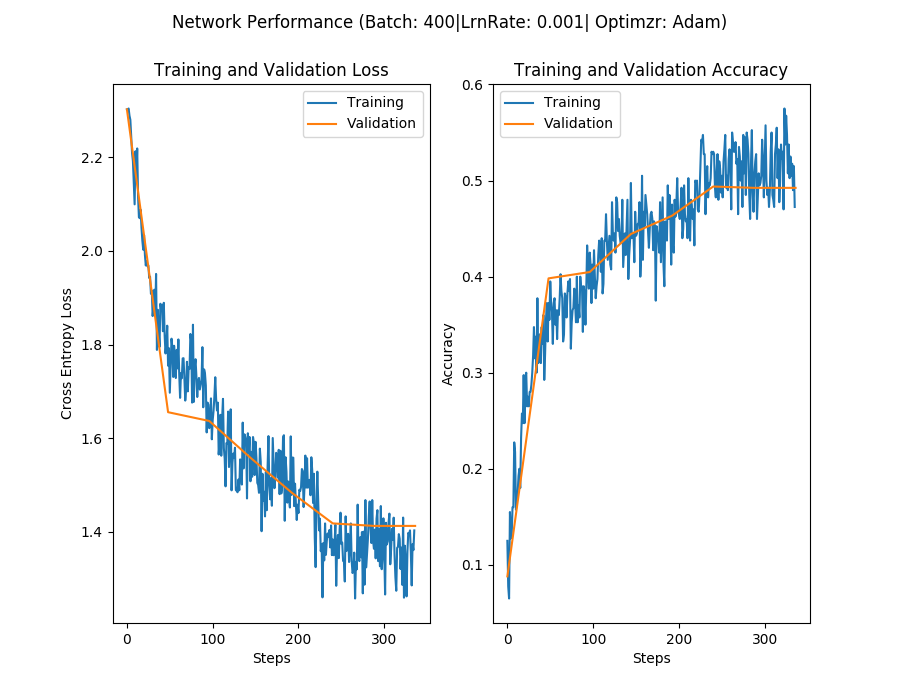

In [9]:
cifar_net.create_and_learn()
cifar_net.plot()

In [10]:
print('The accuracy that we achieved with this network is {:.2f}%.'.format(cifar_net.val_acc_list[-1]*100))

The accuracy that we achieved with this network is 49.24%.


# Task 7
Now let's optimize our network.  We won't try as many combinations because the network takes quite some time to train

<IPython.core.display.Javascript object>


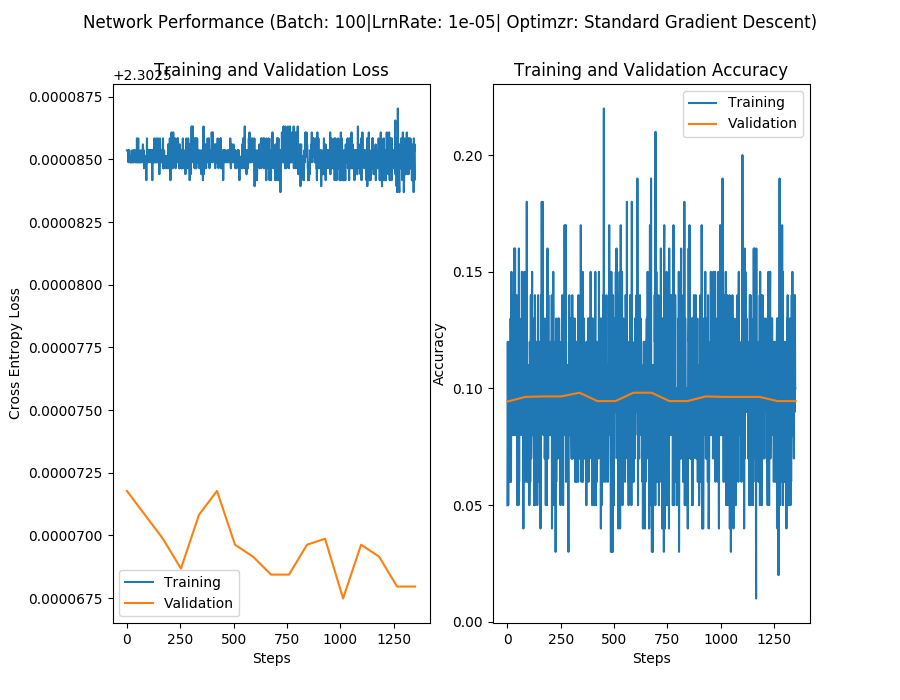

The performance of this network on the validation data is:
Accuracy: 9.46%
Loss: 2.30


<IPython.core.display.Javascript object>


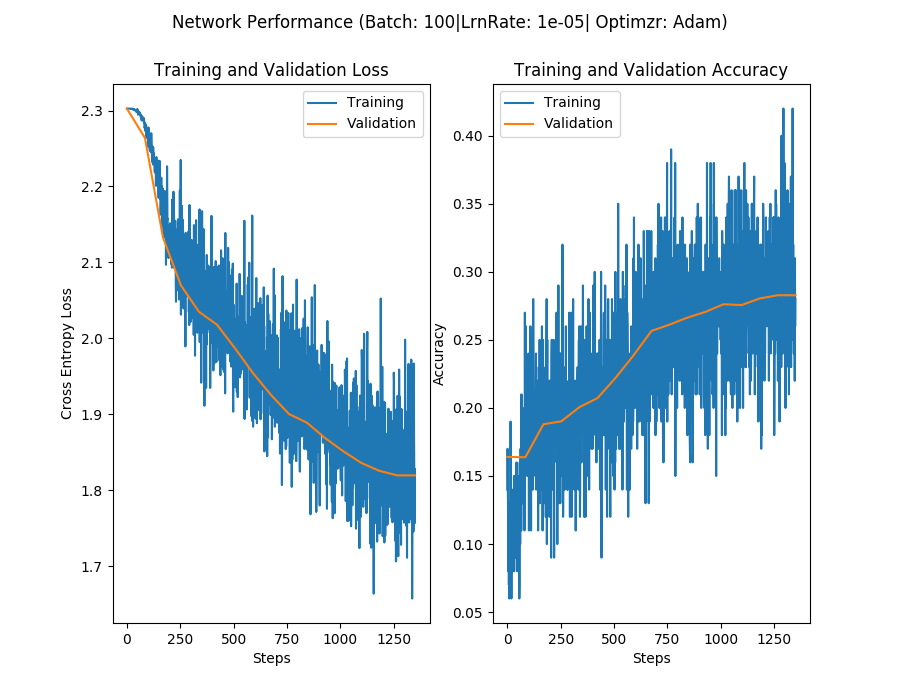

The performance of this network on the validation data is:
Accuracy: 28.28%
Loss: 1.82


<IPython.core.display.Javascript object>


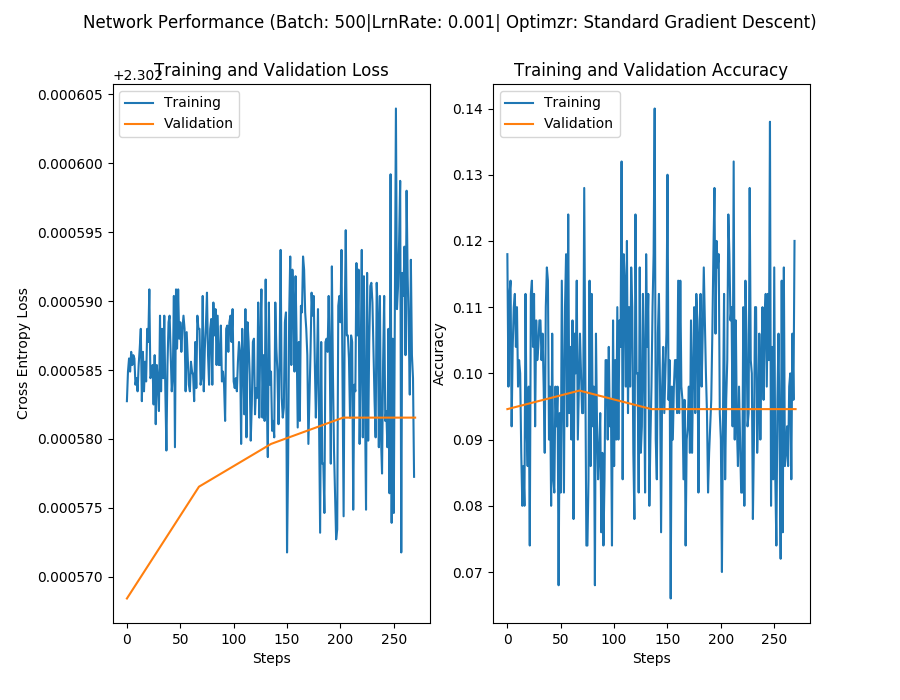

The performance of this network on the validation data is:
Accuracy: 9.46%
Loss: 2.30


<IPython.core.display.Javascript object>


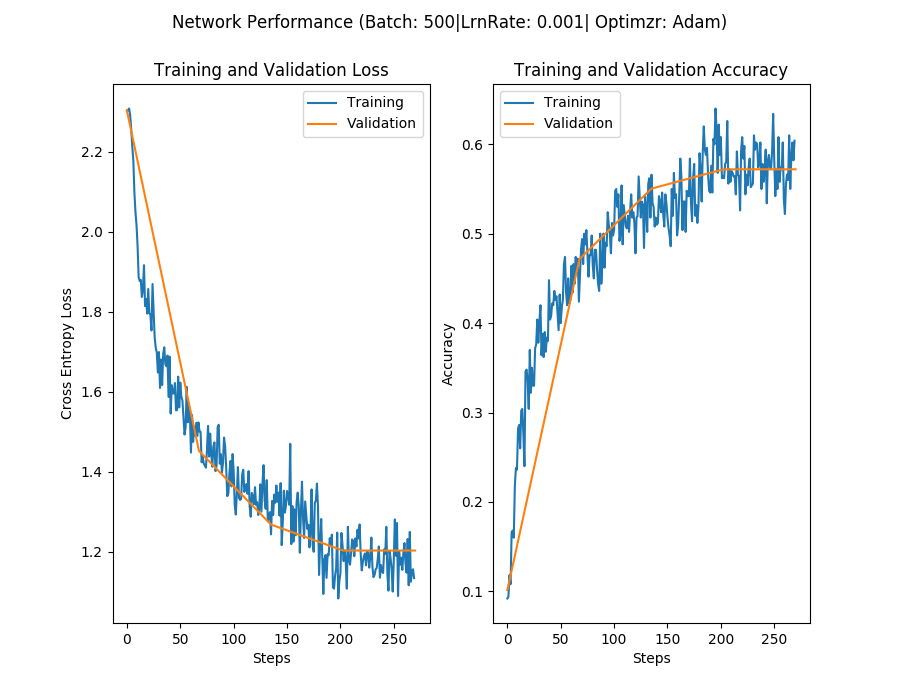

The performance of this network on the validation data is:
Accuracy: 57.20%
Loss: 1.20


In [11]:
test_cases = []
test_cases.append([100,.00001, 'sgd', False])
test_cases.append([100,.00001, 'adam', False])
test_cases.append([500,.001, 'sgd', False])
test_cases.append([500,.001, 'adam', False])

for t in range(len(test_cases)):
    net = Conv_Net(batchsize=test_cases[t][0], epoch_num=3, lr=test_cases[t][1], optimizer=test_cases[t][2], norm=test_cases[t][3])
    net.create_and_learn()
    net.plot()
    print("The performance of this network on the validation data is:\nAccuracy: {:.2%}\nLoss: {:.2f}".format(net.val_acc_list[-1], net.val_loss_list[-1]))

Let's see if there is any difference if we normalize the input images or not...

<IPython.core.display.Javascript object>


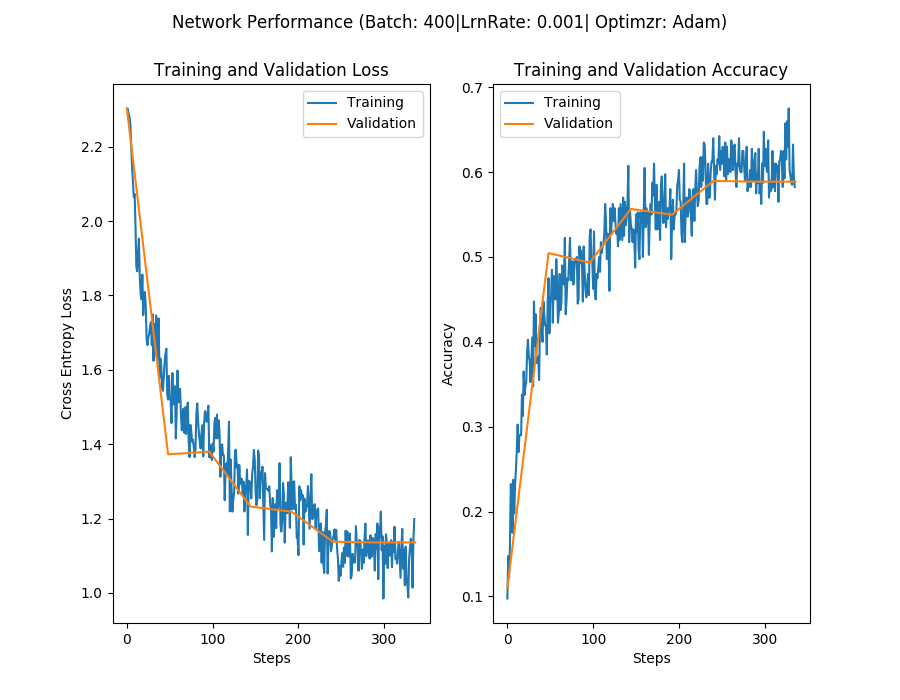

NO NORMALIZATION: The performance of this network on the validation data is:
Accuracy: 58.88%
Loss: 1.14


<IPython.core.display.Javascript object>


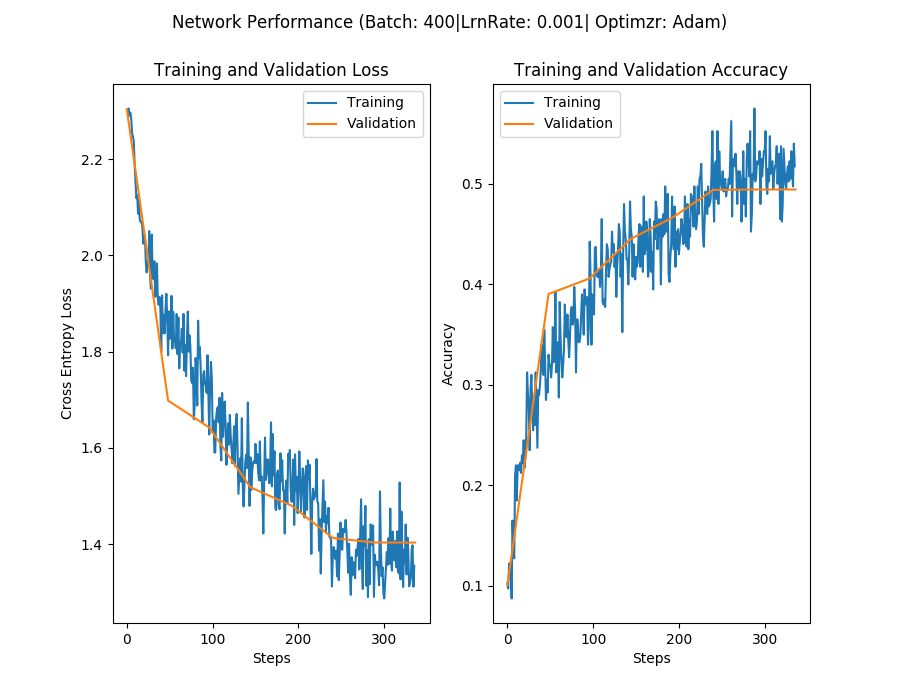

WITH NORMALIZATION: The performance of this network on the validation data is:
Accuracy: 49.44%
Loss: 1.40


In [13]:
without_norm = [400,.001, 'adam', False]
with_norm = [400,.001, 'adam', True]

net = Conv_Net(batchsize=without_norm[0], epoch_num=3, lr=without_norm[1], optimizer=without_norm[2], norm=without_norm[3])
net.create_and_learn()
net.plot()
print("NO NORMALIZATION: The performance of this network on the validation data is:\nAccuracy: {:.2%}\nLoss: {:.2f}".format(net.val_acc_list[-1], net.val_loss_list[-1]))

net = Conv_Net(batchsize=with_norm[0], epoch_num=3, lr=with_norm[1], optimizer=with_norm[2], norm=with_norm[3])
net.create_and_learn()
net.plot()
print("WITH NORMALIZATION: The performance of this network on the validation data is:\nAccuracy: {:.2%}\nLoss: {:.2f}".format(net.val_acc_list[-1], net.val_loss_list[-1]))

## Application Phase
Well, that's weird.  With normalized images, the network performs almost 10% less accurately.  Regardless, we now know which parameters lead to the best validation results, so we'll run that network on the test set and see what happens: 400 batch size, .001 learning rate, with Adam optimizer, without normalization.

The final network produces results of

ACCURACY: 57.01%
LOSS: 1.20


The hyperparameters and optimizer were:


BATCH SIZE: 400
LEARNING RATE: 0.001
EPOCHS: 3
NORMALIZATION: False
OPTIMIZER: Adam


<IPython.core.display.Javascript object>


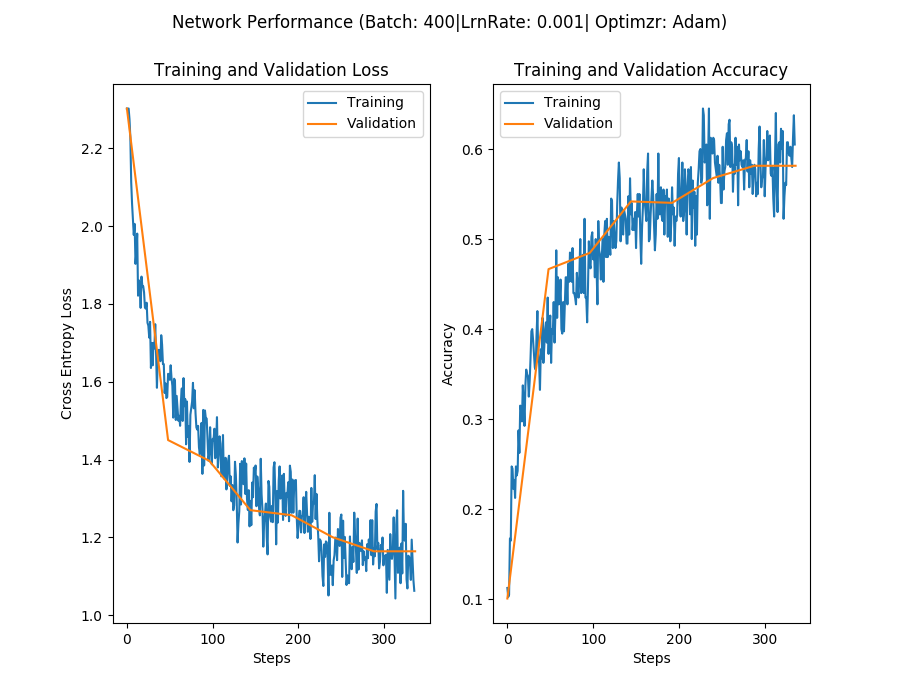

In [15]:
final_net = Conv_Net(batchsize=400, epoch_num=3, lr=.001, optimizer='adam', norm=False)
final_net.create_and_learn()
final_net.plot()